# Image classification

## 0. Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 1. Download and explore the dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


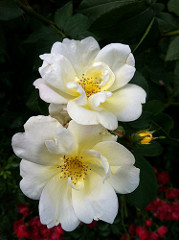

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

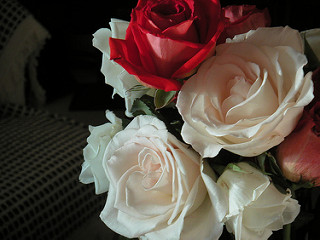

In [5]:
PIL.Image.open(str(roses[1]))

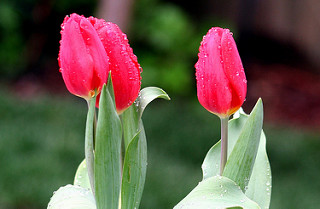

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

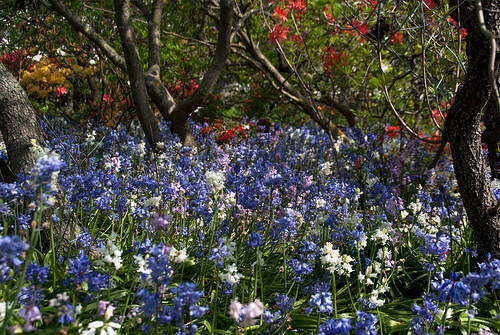

In [7]:
PIL.Image.open(str(tulips[1]))

## 2. Create a dataset

In [8]:
# Define some parameters for the loader:

batch_size = 32
img_height = 180
img_width = 180

In [9]:
# It's good practice to use a validation split when developing your model. 
# Let's use 80% of the images for training, and 20% for validation.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 3. Visualize the data

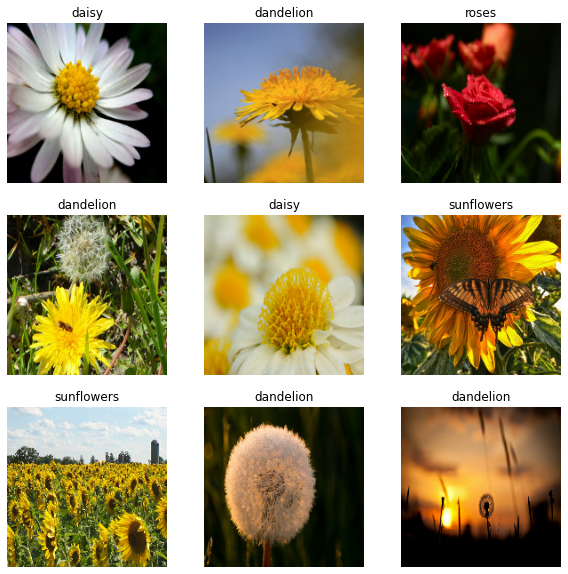

In [15]:
# Here are the first 9 images from the training dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
# You will train a model using these datasets by passing them to model.fit in a moment. 
# If you like, you can also manually iterate over the dataset and retrieve batches of images:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## 4. Configure the dataset for performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5. Standardize the data

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [19]:
# There are two ways to use this layer. 
# You can apply it to the dataset by calling map:

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
# Or, you can include the layer inside your model definition, 
# which can simplify deployment. Let's use the second approach here.

## Create the model

In [21]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 6. Compile the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 7. Model summary

In [23]:
# View all the layers of the network using the model's summary method:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## 8. Train the model

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 6s 46ms/step - loss: 1.4994 - accuracy: 0.3339 - val_loss: 1.0584 - val_accuracy: 0.5817
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.0120 - accuracy: 0.5953 - val_loss: 0.9819 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.8691 - accuracy: 0.6716 - val_loss: 0.8789 - val_accuracy: 0.6676
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.6412 - accuracy: 0.7552 - val_loss: 0.8902 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.3964 - accuracy: 0.8622 - val_loss: 1.0630 - val_accuracy: 0.6621
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2115 - accuracy: 0.9334 - val_loss: 1.2485 - val_accuracy: 0.6390
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1338 - accuracy: 0.9569 - val_loss: 1.4624 - val_accuracy: 0.6526
Epoch 8/10
92

## 9. Visualize training results

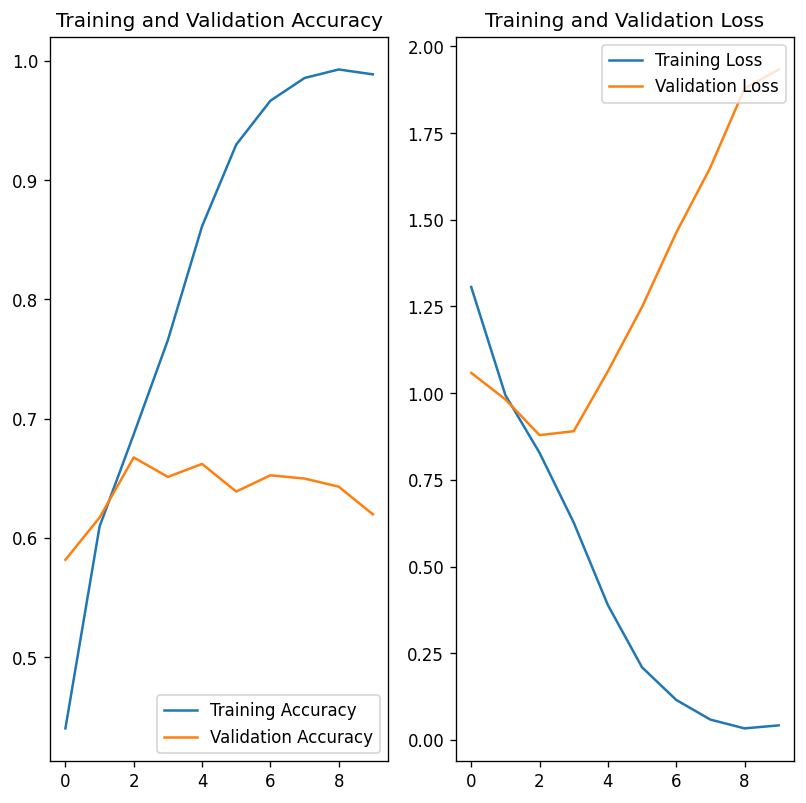

In [25]:
# Create plots of loss and accuracy on the training and validation sets.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=120)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

- Data augmentation
- Dropout

## 10. Data augmentation

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

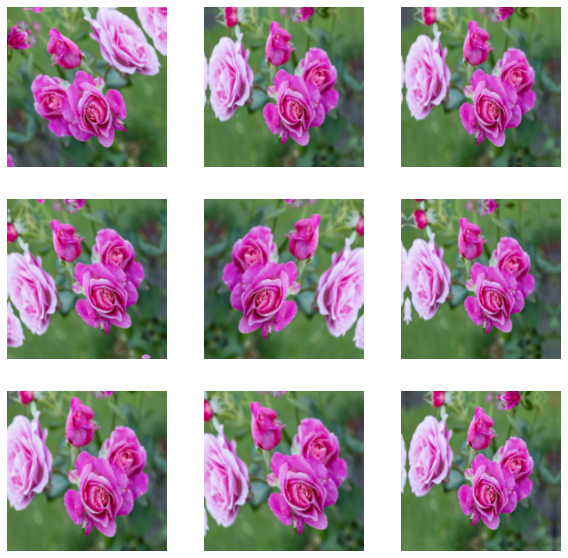

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 11. Dropout

In [28]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [31]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 24ms/step - loss: 1.6857 - accuracy: 0.2429 - val_loss: 1.2021 - val_accuracy: 0.4837
Epoch 2/15
92/92 [==============================] - 2s 22ms/step - loss: 1.1451 - accuracy: 0.5136 - val_loss: 1.0267 - val_accuracy: 0.5804
Epoch 3/15
92/92 [==============================] - 2s 22ms/step - loss: 0.9914 - accuracy: 0.6069 - val_loss: 1.0202 - val_accuracy: 0.5954
Epoch 4/15
92/92 [==============================] - 2s 22ms/step - loss: 0.9546 - accuracy: 0.6294 - val_loss: 0.8888 - val_accuracy: 0.6403
Epoch 5/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8672 - accuracy: 0.6635 - val_loss: 0.8863 - val_accuracy: 0.6499
Epoch 6/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8313 - accuracy: 0.6805 - val_loss: 0.8649 - val_accuracy: 0.6689
Epoch 7/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8187 - accuracy: 0.6743 - val_loss: 0.8385 - val_accuracy: 0.6812
Epoch 8/15
92

## 12. Visualize training results

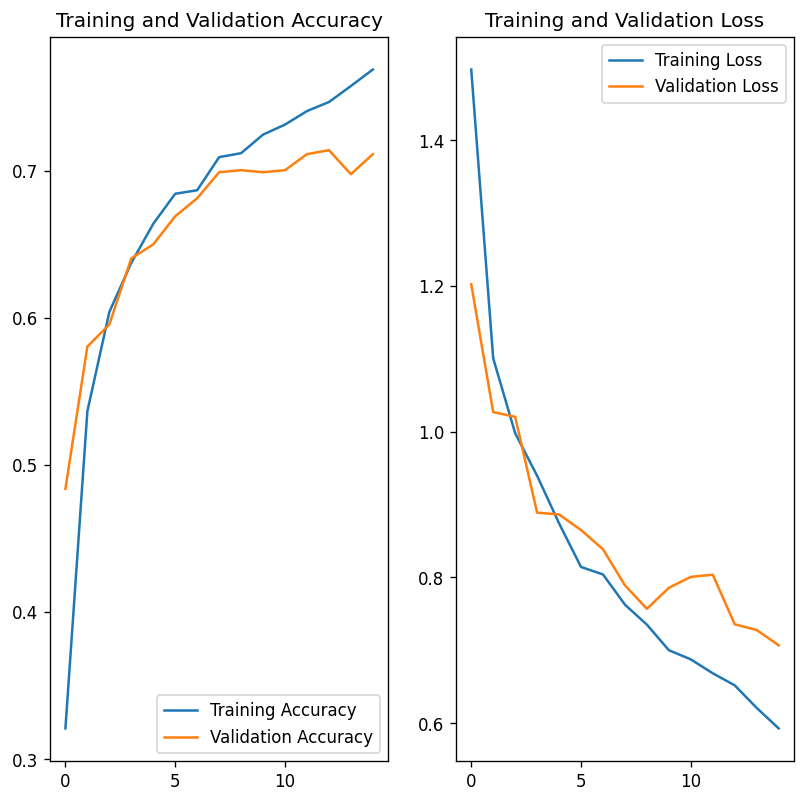

In [33]:
# After applying data augmentation and Dropout, 
# there is less overfitting than before, and training and validation accuracy are closer aligned.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=120)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 13. Predict on new data

In [34]:
# Data augmentation and Dropout layers are inactive at inference time.

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score)))

122880/117948 [===============================] - 0s 1us/step
This image most likely belongs to sunflowers with a 88.63 percent confidence.


# reference
### https://tensorflow.google.cn/tutorials/images/classification#predict_on_new_data